In [1]:
# Works best with jupyter-notebook

In [2]:
%matplotlib notebook 
#%matplotlib widget 
# https://ipython.readthedocs.io/en/stable/interactive/magics.html
import math
import numpy as np

from spatialmath import *
from spatialmath.base import *

import roboticstoolbox as rtb
from roboticstoolbox import *

import matplotlib.pyplot as plt
np.set_printoptions(linewidth=100, formatter={'float': lambda x: f"{x:8.4g}" if abs(x) > 1e-10 else f"{0:8.4g}"})

# Lecture 6.5 Sequence Solutions

This notebook continues IKins but this time we want to visualize sequences of solutions.

---

Under the DHRobot class, we have a number of inverse kinemtic methods that we will study:
https://github.com/petercorke/robotics-toolbox-python/wiki/Kinematics
https://petercorke.github.io/robotics-toolbox-python/arm_dh.html

**Analytic method:**
- sol = ikine_a(T, config='lun'): for specific DH robots only

*Note: Wherever possible use analytic methods as they are much faster and more accurate.*

**Numeric method:**
- sol = ikine_LM(T, q0=None): Numerical inverse kinematics by Levenberg-Marquadt optimization (Robot superclass)

- sol = ikine_min(qlim=True) which uses scipy.minimize with user cost function and stiffness. 

--- 

The elements of the tuple sol include at least:


Element   | Type 	      | Description 
:---|:---|:---
q 	      | ndarray (n)   | Joint coordinates for the solution, or None 
:---|:---|:---
success   | bool 	      | True if a solution found 
:---|:---|:---
reason 	  | str 	      | reason for failure 
:---|:---|:---
iterations| int 	      | number of iterations 
:---|:---|:---
residual  | float 	      | final value of cost function 

---

Note that **numerical IK solvers** minimise a *scalar measure of error* between the current and the desired end-effector pose. The measure is the squared-norm of a 6-vector comprising:

- translational error (a 3-vector)
- the orientation error as an Euler vector (angle/axis form encoded as a 3-vector)

The SciPy based mimimizers are **slow** because they use a scalar cost measure and must *numerically compute a Jacobian* in order to solve.


Let's start by creating a model for the Puma560 robot.

In [3]:
puma = rtb.models.DH.Puma560()

Designate a starting end-effector pose for the puma robot.

In [4]:
T = SE3(0.6, 0.1, 0.5)*SE3().RPY([0, 0, 0], unit='deg')

print(type(T))
print(T)

<class 'spatialmath.pose3d.SE3'>
   1           0           0           0.6          
   0           1           0           0.1          
   0           0           1           0.5          
   0           0           0           1            



Now designate a final configuration and use ctraj to generate a smooth interpolated sequence. 

In [5]:
TF = SE3(0.6, 0.1, 1.0)*SE3().RPY([0, 0, 0], unit='deg')

In [7]:
des_T = ctraj(T,TF,10)
print(len(des_T))

10


To compute a sequence of inverse kinematic solutions:

1. Take your poses and convert them to joint angles via ikin_a
2. Extract the sequence of joint angles into a numpy array matrix
3. Call robot.plot(q) to visualize.

In [10]:
des_q = puma.ikine_a(des_T)
print(des_q)

[IKsolution(q=array([   3.057,    2.644,  0.03708,        0,   -2.681,   -3.057]), success=True, reason=''), IKsolution(q=array([   3.057,    2.616,  0.04935,        0,   -2.666,   -3.057]), success=True, reason=''), IKsolution(q=array([   3.057,    2.534,  0.07996,        0,   -2.614,   -3.057]), success=True, reason=''), IKsolution(q=array([   3.057,    2.403,   0.1103,        0,   -2.514,   -3.057]), success=True, reason=''), IKsolution(q=array([   3.057,    2.261,   0.1126,        0,   -2.374,   -3.057]), success=True, reason=''), IKsolution(q=array([   3.057,     2.14,   0.0777,        0,   -2.217,   -3.057]), success=True, reason=''), IKsolution(q=array([   3.057,    2.044, 0.005584,        0,    -2.05,   -3.057]), success=True, reason=''), IKsolution(q=array([   3.057,    1.988, -0.08328,        0,   -1.904,   -3.057]), success=True, reason=''), IKsolution(q=array([   3.057,    1.964,  -0.1497,        0,   -1.815,   -3.057]), success=True, reason=''), IKsolution(q=array([   3.05

Visualize type, start, and end joint angles

In [11]:
print(type(des_q[0].q))


print(des_q[0].q)
print(des_q[len(des_q)-1].q)

<class 'numpy.ndarray'>
[   3.057    2.644  0.03708        0   -2.681   -3.057]
[   3.057    1.958  -0.1741        0   -1.784   -3.057]


Extract list of angles

In [13]:
q = np.empty([len(des_q), len(des_q[0].q)]) # Create an empty version of all joint angles: T x q

# Fill
for i in range(0,len(des_q)):
    q[i]=des_q[i].q
print(q)

[[   3.057    2.644  0.03708        0   -2.681   -3.057]
 [   3.057    2.616  0.04935        0   -2.666   -3.057]
 [   3.057    2.534  0.07996        0   -2.614   -3.057]
 [   3.057    2.403   0.1103        0   -2.514   -3.057]
 [   3.057    2.261   0.1126        0   -2.374   -3.057]
 [   3.057     2.14   0.0777        0   -2.217   -3.057]
 [   3.057    2.044 0.005584        0    -2.05   -3.057]
 [   3.057    1.988 -0.08328        0   -1.904   -3.057]
 [   3.057    1.964  -0.1497        0   -1.815   -3.057]
 [   3.057    1.958  -0.1741        0   -1.784   -3.057]]


Visualize the robot moving through this sequence of angles. 

<IPython.core.display.Javascript object>


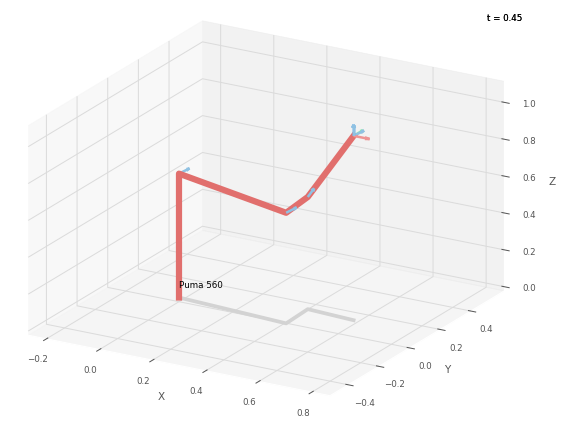

In [14]:
puma.plot(q);

### Solutions with different configurations


By default the inverse kinematics use a configuration of 'lun'. We can test solving the same problem as above with an elbow down.

In [15]:
des_q = puma.ikine_a(des_T, config='ldn')

I will fill the q numpy array again, but this time pythonize the process by using a list comprehension inside and then casting the list as a numpy array.

In [16]:
q = np.array([ des_q[i].q for i in range(0,len(des_q))])
print(type(q))

<class 'numpy.ndarray'>


In [17]:
puma.plot(q);

### Student exercise

Notice that in fact, for any valid pose, there are 8 solutions:
- 2 according to l/r
- 2 according to u/d
- 2 accodgin to w/n

A criteria could be developed to know which configuration accoding to your task.

**Part A**\
- Try generating a trajectory from a 'lun' solution to a 'run' solution.
- Try generating a trajectory from a 'lun' solution to a 'ldn' solution. 

**Part B**\
Try rendering other types of robots that have available models using a swift backend as shown here:
https://github.com/petercorke/robotics-toolbox-python

````
env = rtb.backends.Swift()  # instantiate 3D browser-based visualizer
env.launch()                # activate it
env.add(robot)              # add robot to the 3D scene
for qk in des_q[i].q:       # for each joint configuration on trajectory
    robot.q = qk            # update the robot state
    env.step()
````

Then share your results with the class via piazza under a title: "IKins with Rendered Robots"

**Part C**\
So far, we only found poses with solutions for the puma robot. Could you explore some poses with no solutions?
Post your results to piazza as well under a title: "No IKin Solns"